In [1]:
from os import path
import seaborn as sns
import matplotlib.pyplot as plt

from pymodulon.io import load_json_model
from pymodulon.plotting import *

In [2]:
# Set plotting style
sns.set_style('ticks')
plt.style.use('custom.mplstyle')

### Load data

In [3]:
figure_dir = '../../reports/figures/modulome/Fig3'
data_dir = path.join('../..','data','processed', 'modulome')

data_file = path.join(data_dir,'salb.json.gz')
ica_data = load_json_model(data_file)

In [4]:
gene_info = pd.read_csv('../../data/processed/modulome/merged_gene_info.csv', index_col=0)

#Get a list of imodulon names with function 'Secondary Metabolism'
iModulons = ica_data.imodulon_table[ica_data.imodulon_table['function'] == 'Secondary Metabolism'].index

# Initialize an empty DataFrame with the desired columns
df = pd.DataFrame(columns=['iModulon', 'BGC', 'Total Genes', 'iModulon Coverage'])

# Iterate over all BGCs
for bgc in gene_info['BGC_region'].unique():
    if bgc != 'None':
        # Get the subset of gene_info for the current BGC
        df_bgc_subset = gene_info[gene_info['BGC_region'] == bgc]
        
        # Calculate the total number of genes in the BGC
        total_genes = df_bgc_subset.shape[0]
        
        # Iterate over each iModulon
        for imodulon in iModulons:
            # Calculate the number of genes in the intersection of the BGC and the current iModulon
            intersection_genes = df_bgc_subset[df_bgc_subset['Imodulon'].apply(lambda x: imodulon in str(x).split(', '))].shape[0]
            
            # Calculate the coverage
            coverage = (intersection_genes / total_genes)*100 if total_genes > 0 else 0

            # specify two decimal places
            coverage = round(coverage, 2)
            
            # Append the information to the DataFrame only if intersection_genes > 0
            if intersection_genes > 0:
                df = df.append({'iModulon': imodulon, 'BGC': bgc, 'Total Genes': total_genes, 'iModulon Coverage': coverage}, ignore_index=True)

# Sort the dataframe by iModulon name and then by BGC
df = df.sort_values(by=['iModulon', 'BGC'])

#df.to_csv('../../../../Desktop/preprint_figs/panel3/bgc_coverage.csv')
df.to_clipboard()

In [5]:
# Transpose ica_data.A to make the iModulons the columns and the samples the index
ica_data_A_transposed = ica_data.A.transpose()

# Initialize an empty DataFrame to store the top samples for each iModulon
top_samples_df = pd.DataFrame()

# Iterate over the iModulons in df
for imodulon in df['iModulon'].unique():
    # Get the activities for the current iModulon from ica_data_A_transposed
    imodulon_activities = ica_data_A_transposed[imodulon]
    
    # Get the top 10 samples with the highest absolute activity
    top_samples = imodulon_activities.nlargest(10)
    
    # Convert the Series to a DataFrame and add a column for the iModulon name
    top_samples = top_samples.to_frame(name='Activity').reset_index().rename(columns={'index': 'Sample'})
    top_samples['iModulon'] = imodulon
    
    # Append the top samples for the current iModulon to the overall DataFrame
    top_samples_df = top_samples_df.append(top_samples, ignore_index=True)

# Sort the DataFrame by iModulon name and then by activity
top_samples_df = top_samples_df.sort_values(by=['iModulon', 'Activity'], ascending=[True, False])

# Get the projects for each sample from ica_data.sample_table
top_samples_df['Project'] = top_samples_df['Sample'].apply(lambda x: ica_data.sample_table.loc[x, 'project'])

top_samples_df.to_clipboard()

### Surugamide gene weights

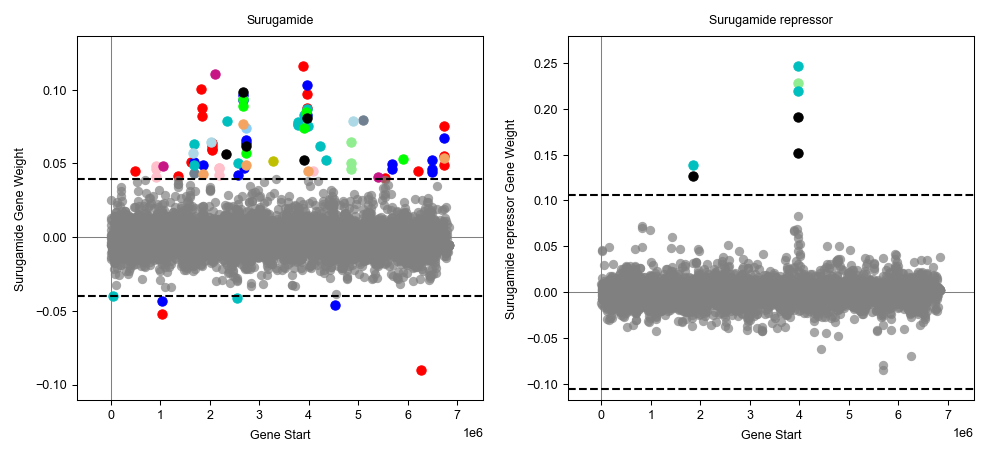

In [6]:
# Set the svg.fonttype parameter to 'none'
plt.rcParams['svg.fonttype'] = 'none'

# Convert the page size from mm to inches
width = 170 / 25.4  # ~6.69 inches
height = 80 / 25.4  # ~3.94 inches

# Define a list of imodulons
imodulons = ['Surugamide','Surugamide repressor']

# Create a grid of subplots with two columns
fig, axs = plt.subplots(len(imodulons)//2 + len(imodulons)%2, 2, figsize=(width, height))

# Loop over the subplots and plot the gene weights
for i, ax in enumerate(axs.flat):
    if i < len(imodulons):
        plot_gene_weights(ica_data, imodulons[i], show_labels=False, label_font_kwargs={'fontsize':6}, ax=ax, legend=False, scatter_kwargs={'s': 20})
        ax.set_title(imodulons[i], fontsize=6)

        # Increase x and y axis text size
        ax.tick_params(axis='both', which='major', labelsize=6)

        # Increase x and y axis label size
        ax.set_xlabel(ax.get_xlabel(), fontsize=6)
        ax.set_ylabel(ax.get_ylabel(), fontsize=6)
    else:
        ax.axis('off')  # Hide unused subplots

plt.tight_layout()
plt.savefig(path.join(figure_dir,'surugamide_weights2.svg'), dpi=300)
plt.show()

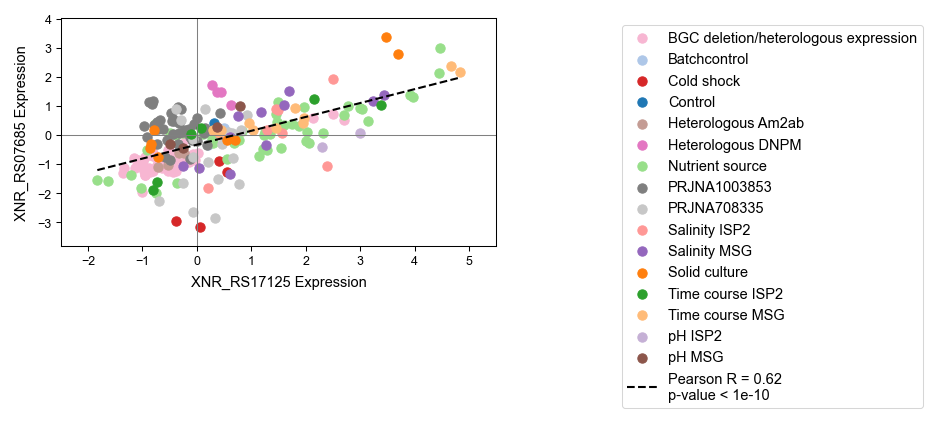

In [7]:
# Convert the page size from mm to inches
width = 95 / 25.4  # ~6.69 inches
height = 50 / 25.4  # ~3.94 inches

fig,ax = plt.subplots(figsize=(width, height))

# Create a dictionary where the keys are the sample IDs and the values are the project names
groups = ica_data.sample_table['project'].to_dict()

# Generate 16 colors from the 'tab20' colormap
colors = plt.cm.tab20(range(16))

# Pass the axes object to compare_expression
compare_expression(ica_data,'XNR_RS17125', 'XNR_RS07685', ax=ax, colors=colors, groups=groups,
                   scatter_kwargs={'s': 20})

# Increase x and y axis text size
ax.tick_params(axis='both', which='major', labelsize=6)

# Increase the x and y-axis label size
#ax.set_xlabel('Surugamide repressor', fontsize=6)
#ax.set_ylabel('Surugamide', fontsize=6)

# Move the legend to the top right outside the plot
ax.legend(loc='upper right', bbox_to_anchor=(2, 1))

plt.savefig(path.join(figure_dir,'surugamide_TFs_expr_correlation.svg'))       

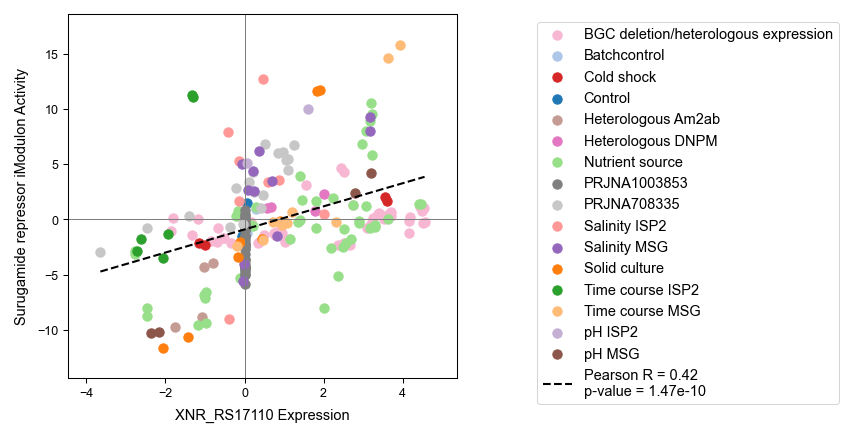

In [9]:
# Convert the page size from mm to inches
width = 85 / 25.4  # ~6.69 inches
height = 80 / 25.4  # ~3.94 inches

fig,ax = plt.subplots(figsize=(width, height))

# Create a dictionary where the keys are the sample IDs and the values are the project names
groups = ica_data.sample_table['project'].to_dict()

# Generate 16 colors from the 'tab20' colormap
colors = plt.cm.tab20(range(16))

# Pass the axes object to compare_expression
compare_imodulon_gene(ica_data,'Surugamide repressor', 'XNR_RS17110', ax=ax, colors=colors, groups=groups,
                   scatter_kwargs={'s': 20})

# Increase x and y axis text size
ax.tick_params(axis='both', which='major', labelsize=6)

# Increase the x and y-axis label size
#ax.set_xlabel('Surugamide repressor', fontsize=6)
#ax.set_ylabel('Surugamide', fontsize=6)

# Move the legend to the top right outside the plot
ax.legend(loc='upper right', bbox_to_anchor=(2, 1))

plt.savefig(path.join(figure_dir,'surugamide_TFs_expr_correlation.svg'))       